In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/Users/akito_harada/Documents/python/stats/ml/venv/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [11]:
dat = pd.read_csv('data/morley.csv').values.ravel()

In [12]:
dat

array([299850., 299740., 299900., 300070., 299930., 299850., 299950.,
       299980., 299980., 299880., 300000., 299980., 299930., 299650.,
       299760., 299810., 300000., 300000., 299960., 299960., 299960.,
       299940., 299960., 299940., 299880., 299800., 299850., 299880.,
       299900., 299840., 299830., 299790., 299810., 299880., 299880.,
       299830., 299800., 299790., 299760., 299800., 299880., 299880.,
       299880., 299860., 299720., 299720., 299620., 299860., 299970.,
       299950., 299880., 299910., 299850., 299870., 299840., 299840.,
       299850., 299840., 299840., 299840., 299890., 299810., 299810.,
       299820., 299800., 299770., 299760., 299740., 299750., 299760.,
       299910., 299920., 299890., 299860., 299880., 299720., 299840.,
       299850., 299850., 299780., 299890., 299840., 299780., 299810.,
       299760., 299810., 299790., 299810., 299820., 299850., 299870.,
       299870., 299810., 299740., 299810., 299940., 299950., 299800.,
       299810., 2998

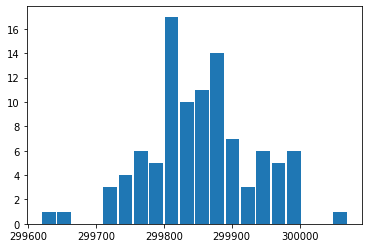

In [14]:
plt.hist(dat, bins = 20, rwidth=0.9)
plt.show();

In [21]:
x = np.random.uniform(size = 10)

In [22]:
np.max(x)

0.950780118654689

In [23]:
# データ数が増えれば増えるほど、母数パラメータを推定する精度は高くなる
x = np.random.uniform(size = 100)
np.max(x)

0.98989663622538

In [35]:
n = 10
x = np.random.uniform(size = n)
((n+1)/ n) * np.max(x)

1.044405855772563

In [36]:
# 100セットデータを生成
X = np.random.rand(100, n)
X.shape

(100, 10)

In [38]:
# 最尤推定の平均値
# np.amaxで行列Xの各行(axis = 1)にmaxを適応。それらの平均値を求める
np.mean(np.max(X, axis = 1))

0.9218399859596832

In [39]:
# 普遍推定の平均値
np.mean((n+1)/n * np.max(X, axis = 1))

1.0140239845556516

In [40]:
df = pd.DataFrame(X)

In [41]:
# 最尤推定の平均値
np.mean(df.apply(np.max, axis = 1))

0.9218399859596832

In [42]:
# 普遍推定の平均値
np.mean(df.apply(lambda x: (n+1)/n * np.max(x), axis = 1))


1.0140239845556516

In [43]:
from scipy.optimize import fmin

In [44]:
# fminは最小を推定するので最大尤度をするように負の尤度関数を作る
# theta = np.array([thetaA, thetaB])
# n= np.array([nA, nB, nAB, nO])
def nlikelihood(theta, n):
    a, b, o = theta[0], theta[1], 1-theta[0] - theta[1]
    p = np.array([a **2 + 2*a*o, b**2 + 2*b*o, 2*a*b, o**2])
    return (-np.sum(n * np.log(p)))

In [45]:
# 最尤推定値の計算
# 入力 n = np.array([nA, nB, nAB, nO])
# 出力 [thetaA, thetaB, thetaC]
# 1/3にした理由はa, b, cの3つの確率変数だから
def mle(n):
    sol = fmin(nlikelihood, [1/3, 1/3], args = (n, ))
    return np.array([sol[0], sol[1], 1-np.sum(sol)])

In [47]:
# A:40, B: 30, AB:10, O:20
n = np.array([40, 30, 10, 20])

In [48]:
mle(n)

Optimization terminated successfully.
         Current function value: 128.937985
         Iterations: 29
         Function evaluations: 55


array([0.29787785, 0.22930651, 0.47281564])

In [56]:
# EMアルゴリズム
class EMmixBernoulli:
    def __init__(self, K = 5, maxitr = 1000, tol = 1e-5, succ = 3):
        self.K = K # コンポーネント数
        self.maxitr = maxitr # EMアルゴリズムの最大反復数
        self.tol = tol; self.succ = succ # 収束判定パラメータ
        
    def fit(self, x):
        K = self.K; maxitr = self.maxitr
        tol = self.tol; succ = self.succ
        n, d = x.shape # データ数nと次元d
        #  マシンイプシロン(https://qiita.com/yoshi1406/items/9ac6cacf253d1c74e900)
        eps = np.finfo(float).eps
        # コンポーネントの初期設定
        mu = np.mean(x)
        # 共役事前分布(https://ai-trend.jp/basic-study/bayes/conjugate-prior-distribution/)
        p = np.random.beta(mu, 1-mu, size = K * d).reshape(K, d)
        # np.repeatの使い方(https://python.atelierkobato.com/numpy_repeat/)
        q = np.repeat(1/K, K)
        ul = np.inf
        converge_ = False
        succ_dec = np.repeat(False, succ)
        # パラメータ更新
        for itr in np.arange(maxitr):
            # 多次元ベルヌーイ分布の確率を計算
            mp = (np.exp(np.dot(np.log(p), x.T) + np.dot(np.log(1-p), 1-x.T)).T*q).T
            # gmm, q, pの更新. np.clipで発散を防ぐ
            gmm = np.clip(mp/np.sum(mp, 0), eps, 1-eps)
            q = np.clip(np.sum(gmm, 1)/n, eps, 1-eps)
            p = np.clip((np.dot(gmm, x).T/(n*q)).T, eps, 1-eps)
            # 負の対数尤度
            lp = np.dot(np.log(p), x.T) + np.dot(np.log(1-p), 1-x.T)
            uln = -np.sum(gmm * ((lp.T + np.log(q)).T - np.log(gmm)))
            succ_dec = np.append((ul - uln > 0) and (ul - uln < tol), succ_dec)[:succ]
            # 停止条件: 減少量が連続succ回tol未満
            if all(succ_dec):
                converge_ = True
                break
            # ulは最尤推定量(つまりmax)
            ul = uln
        # モデルパラメータをBayes流で推定するならばBIC。最尤法で求めるならAIC
        BIC = ul + 0.5 * (d*K + (K-1)) * np.log(n) # BIC
        self.p = p; self.q = q; self.BIC = BIC; self.gmm = gmm
        self.converge_ = converge_; self.itr = itr
        return self
    
    # クラスタ所属確率
    def predict_proba(self, newx):
        p = self.p; q = self.q
        # 同時確率
        jp = np.exp(np.dot(np.log(p), newx.T) + np.dot(np.log(1-p), 1-newx.T)).T * q
        # 周辺確率
        mp = np.sum(jp, 1)
        # 条件付き確率
        cp = (jp.T / mp).T
        return cp
    
    # クラスタ予測
    def predict(self, newx):
        # 条件付き確率の計算
        cp = self.predict_proba(newx)
        cl = np.argmax(cp, axis = 1)
        return cl
    


In [57]:
# データを読み込む
a = pd.read_csv('data/optdigits_train.csv')
x = a.values[:, 0:64] > 8
x.shape

(3822, 64)

In [58]:
y = a.values[:, 64] # 各画像データのラベル。混合モデルの推定には使わない

In [59]:
# 混合ベルヌーイ分布でデータの分布を推定
em = EMmixBernoulli(K = 10) # コンポーネント数10でインスタンス化
em.fit(x) # EMアルゴリズムでパラメータを推定
ec = em.predict(x) # トレーニングデータをクラスタリング

In [60]:
# 第１コンポーネント(インデックスは0)に所属するデータのラベルを表示
u, c = np.unique(y[ec == 0], return_counts=True)

In [61]:
np.c_[u, c].T

array([[  0,   1,   4,   5,   6,   7],
       [  1,   2, 293,   1,   1,   1]])

In [62]:
# 第3コンポーネント(インデックスは2)に所属するデータのラベルを表示
# np.uniqueの引数にreturn_countsをTrueで指定してやれば、左辺の変数を2つ指定してcountが抽出できる
u, c = np.unique(y[ec == 2], return_counts=True)

In [63]:
np.c_[u, c].T

array([[  0,   1,   2,   3,   5,   8,   9],
       [  5,  11,  11, 335, 124,  40, 243]])

In [64]:
em.BIC

76598.40324945761

In [65]:
# コンポーネント数 Kの候補(パラメータの次元は324から3249)
eml = EMmixBernoulli()

In [66]:
Klist = np.arange(4, 51)
BIClist = np.array([])


In [67]:
for K in Klist:
    eml.K = K
    eml.fit(x)
    BIClist = np.append(BIClist, eml.BIC)

In [68]:
Klist[np.argmin(BIClist)]

26

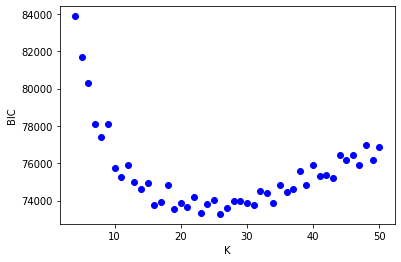

In [70]:
# プロット
plt.xlabel('K');plt.ylabel('BIC')
plt.plot(Klist, BIClist, 'o', color='b')
plt.show();